In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from datasets.image_captioning import *

from utils import load_checkpoint
from models.captioning import CaptionNet

import config

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

%matplotlib inline

In [2]:
network = CaptionNet(n_tokens).to(config.DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-4)

In [3]:
load_checkpoint("captions.pth.tar", network, optimizer, 1e-3)

=> Loading checkpoint


In [4]:
from models.beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/root/.local/lib/python3.6/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [5]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.detach().cpu().numpy()
            next_word_probs = next_word_probs.clip(0)
            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature
            
            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

a mid-swing of people brother somewhere on a skateboard .
a collie is playing speedboat exciting streetlights in the air .
a breaks man in sidecar political a soccer game .
a sniffing man is skillfully inlet on a skateboard .
a touch man in inlet asian a baseball game .
a trimmed man in wrist lettering blood a game of luggage .
a stance in a bushy maybe a game of people .
a athlete in a thre artifacts spots on a skateboard .
a touch man in bushy pantry on a skateboard .
a skirt is playing powdered link in a game .


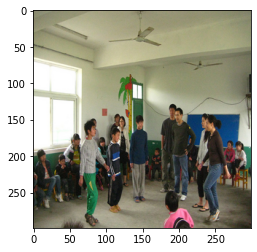

In [19]:
#sample image
path = 'datasets/image_captioning/flickr30k_images/flickr30k_images/'
image = random.choice(os.listdir(path))
img = plt.imread(os.path.join(path, image))
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))